In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
warnings.filterwarnings('ignore')

In [3]:
headers = {
  'Referer': 'https://stats.nba.com/players/shots-dribbles',
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
  'x-nba-stats-origin': 'stats'
}


def get_game_logs(url="https://stats.nba.com/stats/leaguegamefinder?",PlayerOrTeam= "T",LeagueID= "00",Season= '2019-20',
                       SeasonType= 'Playoffs',TeamID= '',VsTeamID= '',PlayerID= '',GameID= '',Outcome= '',Location= '',DateFrom= '',
                       DateTo= '',VsConference= '',VsDivision= '',Conference= '',Division= '',DraftYear= '',DraftNumber= '',
                       DraftRound= '',DraftTeamID= '',RookieYear= '',YearsExperience= '',SeasonSegment= '',PORound= '',
                       StarterBench= '',GtPTS= '',GtREB= '',GtAST= '',GtSTL= '',GtBLK= '',GtOREB= '',GtDREB= '',GtDD= '',
                       GtTD= '',GtMINUTES= '',GtTOV= '',GtPF= '',GtFGM= '',GtFGA= '',GtFG_PCT= '',GtFTM= '',GtFTA= '',
                       GtFT_PCT= '',GtFG3M= '',GtFG3A= '',GtFG3_PCT= '',LtPTS= '',LtREB= '',LtAST= '',LtSTL= '',LtBLK= '',
                       LtOREB= '',LtDREB= '',LtDD= '',LtTD= '',LtMINUTES= '',LtTOV= '',LtPF= '',LtFGM= '',LtFGA= '',
                       LtFG_PCT= '',LtFTM= '',LtFTA= '',LtFT_PCT= '',LtFG3M= '',LtFG3A= '',LtFG3_PCT= '',EqPTS= '',
                       EqREB= '',EqAST= '',EqSTL= '',EqBLK= '',EqOREB= '',EqDREB= '',EqDD= '',EqTD= '',EqMINUTES= '',
                       EqTOV= '',EqPF= '',EqFGM= '',EqFGA= '',EqFG_PCT= '',EqFTM= '',EqFTA= '',EqFT_PCT= '',EqFG3M= '',
                       EqFG3A= '',EqFG3_PCT= ''):
    api_param = locals()
    payload = {}
    response = requests.request("GET",url,params=api_param,headers=headers,data = payload)
    data = response.json()
    df = pd.DataFrame(data['resultSets'][0]['rowSet'],columns=data['resultSets'][0]['headers'])
    return df

def seasons_string(start,end):
    '''
    creates a list of NBA seasons from start-end
    '''
    years = np.arange(start,end+1)
    seasons = []
    for year in years:
        string1 = str(year)
        string2 = str(year+1)
        season = '{}-{}'.format(string1,string2[-2:])
        seasons.append(season)
    return seasons

In [170]:
team_game_logs_df = get_game_logs(PlayerOrTeam="T",SeasonType="Regular Season")

In [171]:
team_game_logs_df["REB_Chances"] = team_game_logs_df["FGA"] - team_game_logs_df["FGM"] + ((team_game_logs_df["FTA"] - team_game_logs_df["FTM"])/2) 

In [172]:
team_game_logs_df_reb = team_game_logs_df[["WL","OREB","REB","DREB","GAME_ID","REB_Chances","TOV"]]

In [173]:
merge_df = team_game_logs_df_reb[team_game_logs_df_reb["WL"] == 'W'].merge(team_game_logs_df_reb[team_game_logs_df_reb["WL"] == 'L'],on="GAME_ID")

In [174]:
merge_df["REB_DIFF"] = merge_df["REB_x"] - merge_df["REB_y"]

In [175]:
merge_df["DREB_PCT_x"] = merge_df["DREB_x"] / merge_df["REB_Chances_y"]
merge_df["DREB_PCT_y"] = merge_df["DREB_y"] / merge_df["REB_Chances_x"]
merge_df["REB_PCT_DIFF"] = merge_df["DREB_PCT_x"] - merge_df["DREB_PCT_y"]

In [176]:
merge_df["REB_DIFF_SIGN"] = np.where(merge_df["REB_DIFF"] < 0 , -1 , 1)
merge_df["REB_PCT_DIFF_SIGN"] = np.where(merge_df["REB_PCT_DIFF"] < 0 , -1 , 1)
merge_df["REB_PCT_DIFF_GROUP"] = round((merge_df["REB_PCT_DIFF"] * 10))
merge_df[(merge_df["REB_PCT_DIFF_GROUP"] >= 2)][["REB_PCT_DIFF","REB_PCT_DIFF_GROUP"]]#.groupby(["WL_x","REB_PCT_DIFF_SIGN"]).count()

,REB_PCT_DIFF,REB_PCT_DIFF_GROUP
2,0.284783,3.0
18,0.238426,2.0
21,0.253369,3.0
37,0.197845,2.0
46,0.157895,2.0
48,0.153333,2.0
59,0.290190,3.0
86,0.160097,2.0
88,0.164193,2.0
89,0.159030,2.0


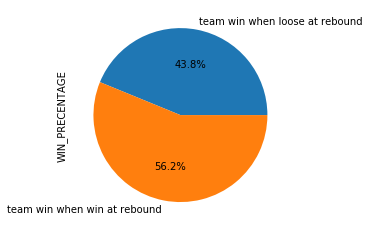

In [177]:
temp_df = ((merge_df.groupby(["WL_x","REB_PCT_DIFF_SIGN"]).count() / merge_df.count()).rename(columns={"DREB_x":"WIN_PRECENTAGE"}))#["WIN_PERCENTAGE"]#.reset_index()#.plot.pie(y="WIN_PRECENTAGE",autopct="%1.1f%%")
temp_df = temp_df.drop(["REB_PCT_DIFF_SIGN","WL_x"],axis=1).reset_index()[["WL_x","REB_PCT_DIFF_SIGN","WIN_PRECENTAGE"]]
temp_df["Reason"] = np.where(temp_df["REB_PCT_DIFF_SIGN"] == -1 , "team win when loose at rebound","team win when win at rebound")
temp_df.set_index("Reason").plot.pie(y="WIN_PRECENTAGE",autopct="%1.1f%%",legend=False)

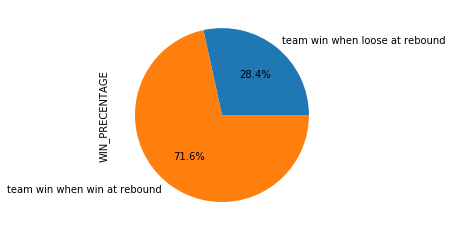

In [178]:
temp_df = ((merge_df.groupby(["WL_x","REB_DIFF_SIGN"]).count() / merge_df.count()).rename(columns={"DREB_x":"WIN_PRECENTAGE"}))#["WIN_PERCENTAGE"]#.reset_index()#.plot.pie(y="WIN_PRECENTAGE",autopct="%1.1f%%")
temp_df = temp_df.drop(["REB_DIFF_SIGN","WL_x"],axis=1).reset_index()[["WL_x","REB_DIFF_SIGN","WIN_PRECENTAGE"]]
temp_df["Reason"] = np.where(temp_df["REB_DIFF_SIGN"] == -1 , "team win when loose at rebound","team win when win at rebound")
temp_df.set_index("Reason").plot.pie(y="WIN_PRECENTAGE",autopct="%1.1f%%",legend=False)

In [179]:
temp_df = ((merge_df.groupby(["WL_x","REB_PCT_DIFF_GROUP"]).count()).rename(columns={"DREB_x":"WIN_PRECENTAGE"}))#["WIN_PERCENTAGE"]#.reset_index()#.plot.pie(y="WIN_PRECENTAGE",autopct="%1.1f%%")
temp_df = temp_df.reset_index()[["WL_x","REB_PCT_DIFF_GROUP","WIN_PRECENTAGE"]]
#temp_df.plot(x="REB_PCT_DIFF_GROUP",y=""#temp_df.set_index("Reason").plot.pie(y="WIN_PRECENTAGE",autopct="%1.1f%%",legend=False)
((merge_df.groupby(["WL_x","REB_PCT_DIFF_GROUP"]).count()).rename(columns={"DREB_x":"WIN_PRECENTAGE"}))

OREB_x  REB_x  WIN_PRECENTAGE  GAME_ID  \
WL_x REB_PCT_DIFF_GROUP                                           
W    -3.0                     5      5               5        5   
     -2.0                    57     57              57       57   
     -1.0                   214    214             214      214   
      0.0                   373    373             373      373   
      1.0                   300    300             300      300   
      2.0                    94     94              94       94   
      3.0                    15     15              15       15   
      4.0                     1      1               1        1   

                         REB_Chances_x  TOV_x  WL_y  OREB_y  REB_y  DREB_y  \
WL_x REB_PCT_DIFF_GROUP                                                      
W    -3.0                            5      5     5       5      5       5   
     -2.0                           57     57    57      57     57      57   
     -1.0                          214    214   214     214    214     214   
      0.0                          373    373   373     373    373     373   
      1.0                          300    300   300     300    300     300   
      2.0                           94     94    94      94     94      94   
      3.0                           15     15    15      15     15      15   
      4.0                            1      1     1       1      1       1   

                         REB_Chances_y  TOV_y  REB_DIFF  DREB_PCT_x  \
WL_x REB_PCT_DIFF_GROUP                                               
W    -3.0                            5      5         5           5   
     -2.0                           57     57        57          57   
     -1.0                          214    214       214         214   
      0.0                          373    373       373         373   
      1.0                          300    300       300         300   
      2.0                           94     94        94          94   
      3.0                           15     15        15          15   
      4.0                            1      1         1           1   

                         DREB_PCT_y  REB_PCT_DIFF  REB_DIFF_SIGN  \
WL_x REB_PCT_DIFF_GROUP                                            
W    -3.0                         5             5              5   
     -2.0                        57            57             57   
     -1.0                       214           214            214   
      0.0                       373           373            373   
      1.0                       300           300            300   
      2.0                        94            94             94   
      3.0                        15            15             15   
      4.0                         1             1              1   

                         REB_PCT_DIFF_SIGN  
WL_x REB_PCT_DIFF_GROUP                     
W    -3.0                                5  
     -2.0                               57  
     -1.0                              214  
      0.0                              373  
      1.0                              300  
      2.0                               94  
      3.0                               15  
      4.0                                1

In [74]:
team_game_logs_df[team_game_logs_df["GAME_ID"] == "0041900313"][["FGA","FGM","FTA","FTM","DREB"]]

,FGA,FGM,FTA,FTM,DREB
4,73,40,29,23,35
5,83,43,22,14,21


In [169]:
merge_df[merge_df["REB_PCT_DIFF_GROUP"] == -2.0]

,WL_x,OREB_x,REB_x,DREB_x,GAME_ID,REB_Chances_x,TOV_x,WL_y,OREB_y,REB_y,DREB_y,REB_Chances_y,TOV_y,REB_DIFF,DREB_PCT_x,DREB_PCT_y,REB_PCT_DIFF,REB_DIFF_SIGN,REB_PCT_DIFF_SIGN,REB_PCT_DIFF_GROUP
66,W,4,36,32,0041900171,47.0,7,L,7,46,39,49.0,12,-10,0.653061,0.829787,-0.176726,-1,-1,-2.0


In [160]:
a = team_game_logs_df[team_game_logs_df["GAME_ID"].isin(merge_df[(merge_df["REB_PCT_DIFF"] != -55)]["GAME_ID"])]
b = a.merge(a,on="GAME_ID")
b = b[b["TEAM_ABBREVIATION_x"] > b["TEAM_ABBREVIATION_y"]]
merge_df[merge_df["REB_PCT_DIFF"] >= 0.2][["REB_PCT_DIFF","REB_PCT_DIFF_GROUP"]]
#.groupby("MATCHUP").count().sort_values("SEASON_ID",ascending=False)

,REB_PCT_DIFF,REB_PCT_DIFF_GROUP
2,0.212121,2.0
3,0.204801,2.0
13,0.414405,4.0
44,0.325170,3.0
46,0.203738,2.0


In [147]:
b.groupby(["TEAM_ABBREVIATION_x","TEAM_ABBREVIATION_y"]).count().reset_index().sort_values("SEASON_ID_x")

,TEAM_ABBREVIATION_x,TEAM_ABBREVIATION_y,SEASON_ID_x,TEAM_ID_x,TEAM_NAME_x,GAME_ID,GAME_DATE_x,MATCHUP_x,WL_x,MIN_x,...,OREB_y,DREB_y,REB_y,AST_y,STL_y,BLK_y,TOV_y,PF_y,PLUS_MINUS_y,REB_Chances_y
2,LAL,DEN,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
4,MIA,BOS,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
5,MIA,IND,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
9,PHI,BOS,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
11,TOR,BKN,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
3,LAL,HOU,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
6,MIL,MIA,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
8,ORL,MIL,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
10,POR,LAL,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
0,LAC,DAL,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [140]:
team_game_logs_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,REB_Chances
0,42019,1610612747,LAL,Los Angeles Lakers,0041900314,2020-09-24,LAL @ DEN,W,240,114,...,12,29,41,23,9,2,9,25,6.0,45.5
1,42019,1610612743,DEN,Denver Nuggets,0041900314,2020-09-24,DEN vs. LAL,L,241,108,...,6,27,33,22,4,3,11,28,-6.0,39.5
2,42019,1610612748,MIA,Miami Heat,0041900304,2020-09-23,MIA vs. BOS,W,240,112,...,10,30,40,20,9,2,8,20,1.2,53.5
3,42019,1610612738,BOS,Boston Celtics,0041900304,2020-09-23,BOS @ MIA,L,239,109,...,12,34,46,28,3,5,19,24,0.2,45.0
4,42019,1610612743,DEN,Denver Nuggets,0041900313,2020-09-22,DEN vs. LAL,W,240,114,...,9,35,44,26,8,2,18,21,8.0,36.0
5,42019,1610612747,LAL,Los Angeles Lakers,0041900313,2020-09-22,LAL @ DEN,L,241,106,...,4,21,25,27,11,3,16,26,-8.0,44.0
6,42019,1610612747,LAL,Los Angeles Lakers,0041900312,2020-09-20,LAL vs. DEN,W,239,105,...,13,31,44,23,9,7,23,30,2.0,46.5
7,42019,1610612743,DEN,Denver Nuggets,0041900312,2020-09-20,DEN @ LAL,L,240,103,...,7,24,31,22,12,4,19,22,-2.0,43.0
8,42019,1610612738,BOS,Boston Celtics,0041900303,2020-09-19,BOS @ MIA,W,240,117,...,10,40,50,27,8,3,14,29,8.4,46.0
9,42019,1610612748,MIA,Miami Heat,0041900303,2020-09-19,MIA vs. BOS,L,239,106,...,12,30,42,21,5,8,13,24,-11.0,55.0
